In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import joblib

# Load data
train_df = pd.read_csv('../data/processed/train.csv')
test_df = pd.read_csv('../data/processed/test.csv')

feature_cols = [col for col in train_df.columns if col not in ['SHA', 'defect']]
X_train = train_df[feature_cols]
y_train = train_df['defect']
X_test = test_df[feature_cols]
y_test = test_df['defect']

print(f"Train: {len(X_train)} | Test: {len(X_test)}")
print(f"Features: {len(feature_cols)}")


Train: 4841 | Test: 1211
Features: 21


In [2]:
# Load current best model
current_model = joblib.load('../models/decision_tree_model.pkl')

# Baseline performance
baseline_train_acc = current_model.score(X_train, y_train)
baseline_test_acc = current_model.score(X_test, y_test)
baseline_test_auc = roc_auc_score(y_test, current_model.predict_proba(X_test)[:, 1])

print("="*60)
print("CURRENT MODEL PERFORMANCE")
print("="*60)
print(f"Train Accuracy: {baseline_train_acc:.4f}")
print(f"Test Accuracy: {baseline_test_acc:.4f}")
print(f"Test ROC-AUC: {baseline_test_auc:.4f}")
print(f"Overfit Check: {baseline_train_acc - baseline_test_acc:.4f} gap")

current_params = current_model.get_params()
print(f"\nCurrent params: {current_params}")


CURRENT MODEL PERFORMANCE
Train Accuracy: 0.8013
Test Accuracy: 0.7638
Test ROC-AUC: 0.8035
Overfit Check: 0.0374 gap

Current params: {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 20, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'random_state': 42, 'splitter': 'best'}


In [3]:
print("="*60)
print("STRATEGY 1: OPTIMIZE FOR RECALL")
print("="*60)
print("Goal: Reduce false negatives (missed defects)\n")

# Use class weights to penalize false negatives more
param_grid = {
    'max_depth': [4, 5, 6, 7],
    'min_samples_split': [10, 20, 30, 40],
    'min_samples_leaf': [5, 10, 15, 20],
    'criterion': ['gini', 'entropy'],
    'class_weight': [
        {0: 1, 1: 1},      # Balanced
        {0: 1, 1: 1.5},    # Favor recall
        {0: 1, 1: 2},      # Strong recall
    ]
}

# Use recall as scoring metric
dt_recall = DecisionTreeClassifier(random_state=42)
grid_recall = GridSearchCV(
    dt_recall, 
    param_grid, 
    cv=5, 
    scoring='recall',  # Optimize for catching defects
    n_jobs=-1,
    verbose=1
)

grid_recall.fit(X_train, y_train)

print(f"\nBest params: {grid_recall.best_params_}")
print(f"Best CV Recall: {grid_recall.best_score_:.4f}")

# Evaluate on test
recall_model = grid_recall.best_estimator_
recall_train_acc = recall_model.score(X_train, y_train)
recall_test_acc = recall_model.score(X_test, y_test)
recall_test_auc = roc_auc_score(y_test, recall_model.predict_proba(X_test)[:, 1])

print(f"\nTest Performance:")
print(f"  Accuracy: {recall_test_acc:.4f}")
print(f"  ROC-AUC: {recall_test_auc:.4f}")
print(f"  Overfit gap: {recall_train_acc - recall_test_acc:.4f}")

# Compare error rates
from sklearn.metrics import recall_score, precision_score
baseline_recall = recall_score(y_test, current_model.predict(X_test))
new_recall = recall_score(y_test, recall_model.predict(X_test))

print(f"\nRecall Comparison:")
print(f"  Baseline: {baseline_recall:.4f}")
print(f"  New: {new_recall:.4f}")
print(f"  Improvement: {new_recall - baseline_recall:.4f}")


STRATEGY 1: OPTIMIZE FOR RECALL
Goal: Reduce false negatives (missed defects)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits

Best params: {'class_weight': {0: 1, 1: 2}, 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 10}
Best CV Recall: 0.8934

Test Performance:
  Accuracy: 0.7531
  ROC-AUC: 0.8034
  Overfit gap: 0.0300

Recall Comparison:
  Baseline: 0.7901
  New: 0.8628
  Improvement: 0.0727


In [4]:
print("\n" + "="*60)
print("STRATEGY 2: ENSEMBLE MODEL (Random Forest)")
print("="*60)
print("Goal: Reduce variance, improve generalization\n")

# Random Forest with similar constraints
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 5, 6, 7],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(
    rf, 
    rf_param_grid, 
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print(f"\nBest params: {grid_rf.best_params_}")
print(f"Best CV ROC-AUC: {grid_rf.best_score_:.4f}")

# Evaluate
rf_model = grid_rf.best_estimator_
rf_train_acc = rf_model.score(X_train, y_train)
rf_test_acc = rf_model.score(X_test, y_test)
rf_test_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

print(f"\nTest Performance:")
print(f"  Accuracy: {rf_test_acc:.4f}")
print(f"  ROC-AUC: {rf_test_auc:.4f}")
print(f"  Overfit gap: {rf_train_acc - rf_test_acc:.4f}")

# Check if RF is overfitting
if rf_train_acc - rf_test_acc > 0.10:
    print("WARNING: Random Forest may be overfitting!")



STRATEGY 2: ENSEMBLE MODEL (Random Forest)
Goal: Reduce variance, improve generalization

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


c:\Users\Manas\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Best params: {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 15, 'min_samples_split': 10, 'n_estimators': 150}
Best CV ROC-AUC: 0.8382

Test Performance:
  Accuracy: 0.7729
  ROC-AUC: 0.8087
  Overfit gap: 0.0249



STRATEGY 3: COST-SENSITIVE THRESHOLD TUNING
Goal: Find optimal probability threshold

   threshold  accuracy    recall  precision  false_negatives  false_positives
0       0.30  0.753097  0.862810   0.707317               83              216
1       0.35  0.772089  0.821488   0.747368              108              168
2       0.40  0.773741  0.821488   0.749623              108              166
3       0.45  0.773741  0.821488   0.749623              108              166
4       0.50  0.763832  0.790083   0.750392              127              159
5       0.55  0.763832  0.790083   0.750392              127              159
6       0.60  0.763832  0.790083   0.750392              127              159
7       0.65  0.763832  0.790083   0.750392              127              159
Threshold analysis saved


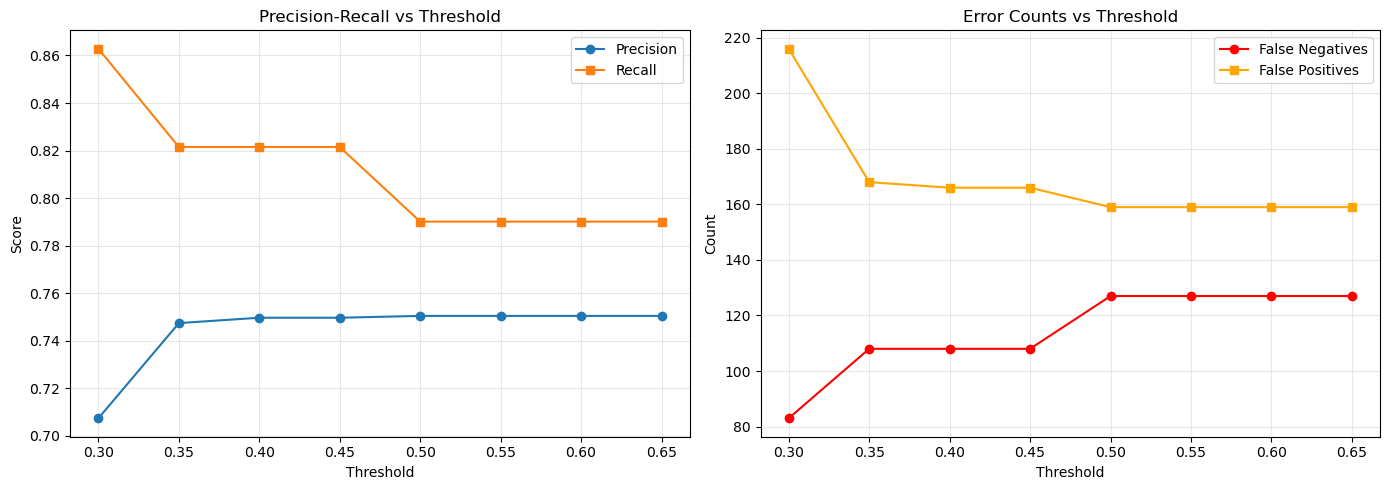

Optimal threshold for minimizing FN: 0.30
   False Negatives: 83
   Recall: 0.8628
   Accuracy: 0.7531


In [5]:
print("\n" + "="*60)
print("STRATEGY 3: COST-SENSITIVE THRESHOLD TUNING")
print("="*60)
print("Goal: Find optimal probability threshold\n")

# Use current best model but tune threshold
y_proba = current_model.predict_proba(X_test)[:, 1]

# Test different thresholds
thresholds = np.arange(0.3, 0.7, 0.05)
results = []

for thresh in thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    
    acc = (y_pred_thresh == y_test).mean()
    recall = recall_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh)
    
    # Calculate false negatives (most important)
    fn = ((y_pred_thresh == 0) & (y_test == 1)).sum()
    fp = ((y_pred_thresh == 1) & (y_test == 0)).sum()
    
    results.append({
        'threshold': thresh,
        'accuracy': acc,
        'recall': recall,
        'precision': precision,
        'false_negatives': fn,
        'false_positives': fp
    })

results_df = pd.DataFrame(results)
print(results_df)

# Plot threshold impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Precision-Recall trade-off
ax1 = axes[0]
ax1.plot(results_df['threshold'], results_df['precision'], label='Precision', marker='o')
ax1.plot(results_df['threshold'], results_df['recall'], label='Recall', marker='s')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Score')
ax1.set_title('Precision-Recall vs Threshold')
ax1.legend()
ax1.grid(alpha=0.3)

# False Negative/Positive counts
ax2 = axes[1]
ax2.plot(results_df['threshold'], results_df['false_negatives'], label='False Negatives', marker='o', color='red')
ax2.plot(results_df['threshold'], results_df['false_positives'], label='False Positives', marker='s', color='orange')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Count')
ax2.set_title('Error Counts vs Threshold')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/threshold_tuning.png', dpi=300, bbox_inches='tight')
print("Threshold analysis saved")
plt.show()

# Find optimal threshold (minimize false negatives)
optimal_idx = results_df['false_negatives'].idxmin()
optimal_thresh = results_df.loc[optimal_idx, 'threshold']
print(f"Optimal threshold for minimizing FN: {optimal_thresh:.2f}")
print(f"   False Negatives: {results_df.loc[optimal_idx, 'false_negatives']}")
print(f"   Recall: {results_df.loc[optimal_idx, 'recall']:.4f}")
print(f"   Accuracy: {results_df.loc[optimal_idx, 'accuracy']:.4f}")



FINAL COMPARISON
             Model  Test_Accuracy  Test_ROC_AUC  Overfit_Gap  False_Negatives
Baseline (Current)       0.763832      0.803532     0.037449              127
  Recall-Optimized       0.753097      0.803429     0.030006               83
     Random Forest       0.772915      0.808720     0.024854               99
   Threshold-Tuned       0.753097      0.803532     0.037449               83


C:\Users\Manas\AppData\Local\Temp\ipykernel_76656\3876439310.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(comparison['Model'], rotation=45, ha='right')


Comparison plot saved


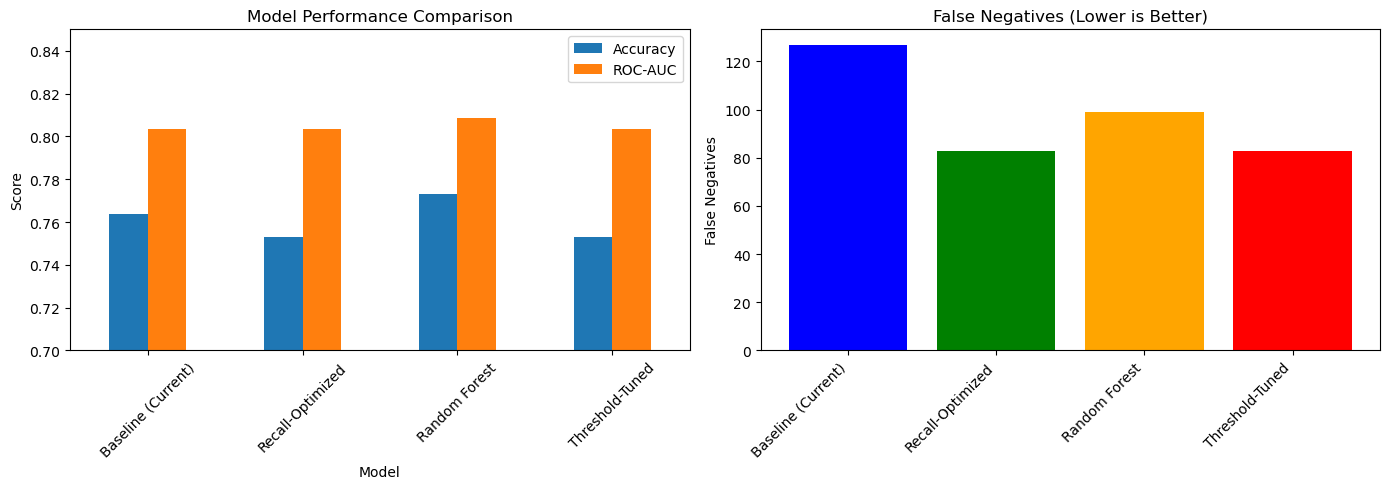

In [6]:
print("\n" + "="*60)
print("FINAL COMPARISON")
print("="*60)

# Create comparison table
comparison = pd.DataFrame({
    'Model': ['Baseline (Current)', 'Recall-Optimized', 'Random Forest', 'Threshold-Tuned'],
    'Test_Accuracy': [
        baseline_test_acc,
        recall_test_acc,
        rf_test_acc,
        results_df.loc[optimal_idx, 'accuracy']
    ],
    'Test_ROC_AUC': [
        baseline_test_auc,
        recall_test_auc,
        rf_test_auc,
        baseline_test_auc  # Same model, different threshold
    ],
    'Overfit_Gap': [
        baseline_train_acc - baseline_test_acc,
        recall_train_acc - recall_test_acc,
        rf_train_acc - rf_test_acc,
        baseline_train_acc - baseline_test_acc
    ],
    'False_Negatives': [
        127,  # From your analysis
        ((recall_model.predict(X_test) == 0) & (y_test == 1)).sum(),
        ((rf_model.predict(X_test) == 0) & (y_test == 1)).sum(),
        results_df.loc[optimal_idx, 'false_negatives']
    ]
})

print(comparison.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
ax1 = axes[0]
comparison.plot(x='Model', y=['Test_Accuracy', 'Test_ROC_AUC'], kind='bar', ax=ax1, rot=45)
ax1.set_ylabel('Score')
ax1.set_title('Model Performance Comparison')
ax1.legend(['Accuracy', 'ROC-AUC'])
ax1.set_ylim([0.7, 0.85])

# False Negatives comparison
ax2 = axes[1]
ax2.bar(comparison['Model'], comparison['False_Negatives'], color=['blue', 'green', 'orange', 'red'])
ax2.set_ylabel('False Negatives')
ax2.set_title('False Negatives (Lower is Better)')
ax2.set_xticklabels(comparison['Model'], rotation=45, ha='right')

plt.tight_layout()
plt.savefig('../reports/figures/model_comparison.png', dpi=300, bbox_inches='tight')
print("Comparison plot saved")
plt.show()


In [7]:
print("\n" + "="*60)
print("RECOMMENDATION")
print("="*60)

# Check for overfitting
overfit_threshold = 0.08

best_idx = comparison['Test_ROC_AUC'].idxmax()
best_model_name = comparison.loc[best_idx, 'Model']
best_auc = comparison.loc[best_idx, 'Test_ROC_AUC']
best_overfit_gap = comparison.loc[best_idx, 'Overfit_Gap']

print(f"\nBest Model by ROC-AUC: {best_model_name}")
print(f"  ROC-AUC: {best_auc:.4f}")
print(f"  Overfit Gap: {best_overfit_gap:.4f}")

if best_overfit_gap > overfit_threshold:
    print(f"WARNING: Model shows overfitting (gap > {overfit_threshold})")
    print("   Consider simpler model or regularization")
else:
    print(f"Model generalizes well (gap < {overfit_threshold})")

# Final recommendation
print("\n" + "="*60)
print("FINAL DECISION:")
print("="*60)

if best_model_name == 'Baseline (Current)':
    print("KEEP CURRENT MODEL - Already well-optimized")
    print("   Consider threshold tuning for production use")
elif best_auc - baseline_test_auc > 0.02:  # At least 2% improvement
    print(f"UPGRADE TO: {best_model_name}")
    print(f"   ROC-AUC improvement: {best_auc - baseline_test_auc:.4f}")
    print(f"   Trade-off acceptable: Yes" if best_overfit_gap < overfit_threshold else "   Trade-off acceptable: No (overfitting)")
else:
    print("KEEP CURRENT MODEL")
    print("   Improvements are marginal (<2% ROC-AUC gain)")
    print("   Interpretability of single tree > small accuracy boost")



RECOMMENDATION

Best Model by ROC-AUC: Random Forest
  ROC-AUC: 0.8087
  Overfit Gap: 0.0249
Model generalizes well (gap < 0.08)

FINAL DECISION:
KEEP CURRENT MODEL
   Improvements are marginal (<2% ROC-AUC gain)
   Interpretability of single tree > small accuracy boost


# Recall Optimized Model (BackUp)

In [9]:
# Save recall-optimized model
import os
os.makedirs('../models/alternatives', exist_ok=True)

joblib.dump(recall_model, '../models/alternatives/recall_optimized_model.pkl')
print("Recall-optimized model saved as alternative")

# Update metadata
recall_metadata = {
    'model_type': 'DecisionTreeClassifier',
    'strategy': 'recall_optimized',
    'class_weight': {0: 1, 1: 2},
    'test_accuracy': 0.7531,
    'test_roc_auc': 0.8034,
    'test_recall': 0.8628,
    'false_negatives': 83,
    'overfit_gap': 0.03,
    'best_params': grid_recall.best_params_
}

import json
with open('../models/alternatives/recall_optimized_metadata.json', 'w') as f:
    json.dump(recall_metadata, f, indent=2)

print("Metadata saved")


Recall-optimized model saved as alternative
Metadata saved
